In [33]:
import numpy as np
import pickle
from pathlib import Path
import time
import torch
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
%matplotlib inline 
from torchsummary import summary
from torcheval import metrics
import torch.nn as nn


In [34]:
## select series with real wildfire
# %pip install torchsummary torcheval livelossplot

In [35]:
if torch.cuda.is_available(): 
 dev = "cuda" 
else: 
 dev = "cpu" 
device = torch.device(dev) 


In [36]:
data_path =  'wildfire/Ferguson_fire_train.npy'
train_data = np.load(data_path).reshape(125,100,256,256)
test_path =  'wildfire/Ferguson_fire_test.npy'
test_data = np.load(test_path).reshape(50,100,256,256)

# count1 =0
# idx = []
# for i in range(len(train_data)):
#     if train_data[i].sum()/99>3000:
#         count1+=1
#         idx.append(i)
# train_data = train_data[idx]
# print("Number of significant wildfires in train data: ",count1)
# count2 =0
# idx = []
# for i in range(len(test_data)):
#     if test_data[i].sum()/99>3000:
#         count2+=1
#         idx.append(i)
# test_data = test_data[idx]
# print("Number of significant wildfires in test data: ",count2)


In [37]:
train_4d=train_data[:,::10,:,:][:,:-1,:,:].reshape(-1,256,256)
train_shift_4d=train_data[:,::10,:,:][:,1:,:,:].reshape(-1,256,256)

test_4d=test_data[:,::10,:,:][:,:-1,:,:].reshape(-1,256,256)
test_shift_4d=test_data[:,::10,:,:][:,1:,:,:].reshape(-1,256,256)

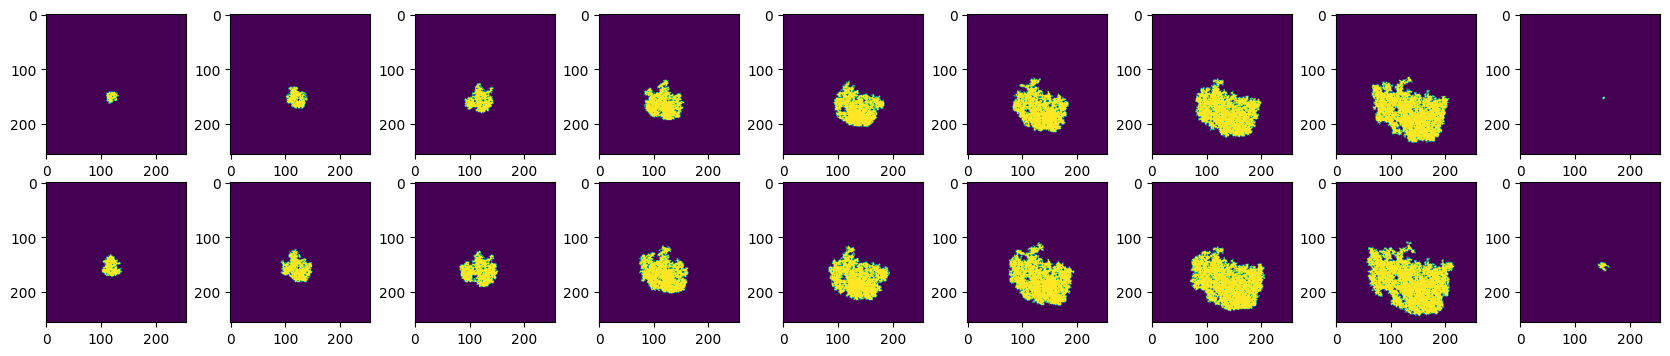

In [38]:
fig, axs = plt.subplots(2,9, figsize=(21,4))

for i in range(9):
    axs[0,i].imshow(train_4d[1000+i*10])
    axs[1,i].imshow(train_shift_4d[1000+i*10])

In [39]:

# Create pairs for training data
train_pairs = np.stack((train_4d, train_shift_4d), axis=1).reshape(-1, 2, 256, 256)

# Create pairs for test data
test_pairs = np.stack((test_4d, test_shift_4d), axis=1).reshape(-1, 2, 256, 256)

# Create TensorDataset
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_pairs[:, 0], dtype=torch.float32), torch.tensor(train_pairs[:, 1], dtype=torch.float32))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_pairs[:, 0], dtype=torch.float32), torch.tensor(test_pairs[:, 1], dtype=torch.float32))

# Create DataLoaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
# del train_data, test_data, train_dataset, test_dataset, test_pairs, train_pairs, train_shift_4d, test_shift_4d

### Code for Training the Model in model_training.ipynb notebook

In [65]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, latent_dim=16, input_channels=1):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 128, 128)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 64, 64)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, 32, 32)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: (256, 16, 16)
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # Output: (512, 8, 8)
            nn.ReLU(),
            nn.Dropout(),
            nn.Flatten()
        )

        # Compute the size of the flattened feature map after the convolutions
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, 256, 256)
            flattened_size = self.encoder(dummy_input).shape[1]

        self.fc_mu = nn.Linear(flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(flattened_size, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, flattened_size)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (512, 8, 8)),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # Output: (256, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 64, 64)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 128, 128)
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1),  # Output: (1, 256, 256)
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_input(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar



#### Show layers in my model

In [66]:

model = VAE(latent_dim  =64
             ).to(device)
summary(model, (1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             544
              ReLU-2         [-1, 32, 128, 128]               0
            Conv2d-3           [-1, 64, 64, 64]          32,832
              ReLU-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 32, 32]         131,200
              ReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 16, 16]         524,544
              ReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9            [-1, 512, 8, 8]       2,097,664
             ReLU-10            [-1, 512, 8, 8]               0
          Flatten-11                [-1, 32768]               0
           Linear-12                   [-1, 64]       2,097,216
           Linear-13                   [-1, 64]       2,097,216
           Linear-14                [-1

In [67]:
def train(model, optimizer, criterion, dataloader, scheduler = 0):
    model.train()
    train_loss = 0
    for (X,Y) in dataloader:
        X = X.to(device).view(-1,1,256,256)
        Y=Y.to(device).view(-1,1,256,256)
        optimizer.zero_grad()
        a2, mu, logvar =model(X)
        loss = criterion(Y, a2, mu, logvar)
        loss.backward()
        train_loss += loss*X.size(0)
        optimizer.step()
        if scheduler !=0:
            scheduler.step()

    return train_loss/len(dataloader.dataset)
  
def validate(model, criterion, dataloader):
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for (X,Y) in dataloader:
            
            X = X.to(device).view(-1,1,256,256)
            Y=Y.to(device).view(-1,1,256,256)
            a2, mu, logvar =model(X)
            loss = criterion(Y, a2, mu, logvar)
            valid_loss += loss*X.size(0)
    return valid_loss/len(dataloader.dataset)

In [68]:

# def train( model,optimizer,criterion, train_loader):
#     model.train()
#     train_loss = 0
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data = data.to(device).view(-1,1, 256,256)  # Flatten the input images
#         target = target.to(device).view(target.size(0),1, 256,256)  # Flatten the target images
#         optimizer.zero_grad()
#         recon_batch, mu, logvar = model(data)
#         loss = criterion(recon_batch, target, mu, logvar)
#         loss.backward()
#         train_loss += loss
#         optimizer.step()
#     avg_train_loss = train_loss / len(train_loader.dataset)
#     return avg_train_loss

# def validate( model,criterion, val_loader):
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for data, target in val_loader:
#             data = data.view(-1,1, 256,256).to(device)  # Flatten the input images
#             target = target.view(target.size(0),1, 256,256).to(device)  # Flatten the target images
#             recon_batch, mu, logvar = model(data)
#             loss = criterion(recon_batch, target, mu, logvar)
#             val_loss += loss
#     avg_val_loss = val_loss / len(val_loader.dataset)
#     return avg_val_loss

In [69]:


def loss_function(x, x_hat, mu, logvar,beta=2):

    # MSE loss
    
    reproduction_loss = loss(x_hat, x)#, reduction='mean')
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return reproduction_loss + beta*KLD

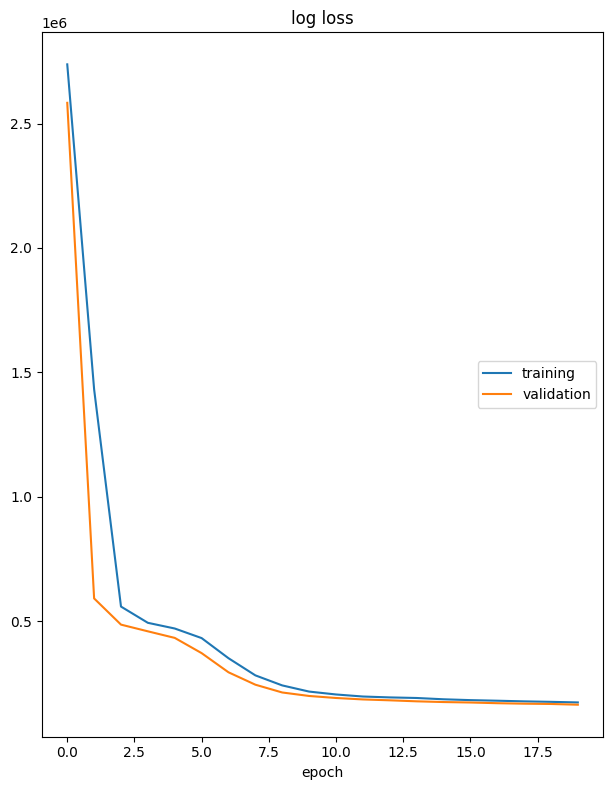

log loss
	training         	 (min: 173651.750, max: 2737796.250, cur: 173651.750)
	validation       	 (min: 164532.094, max: 2583195.250, cur: 164532.094)


In [70]:
epochs = 20

# save_path = "VAE.pth"
# try: 
#     model.load_state_dict(torch.load("VAE.pth",map_location='cpu'))
# except FileNotFoundError:

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
 
loss = nn.BCELoss(reduction='sum')

liveloss = PlotLosses()
for epoch in range(epochs):
    logs = {}
    loss1 = train(model, optimizer,loss_function, trainloader)
    
    loss2 = validate(model,loss_function, testloader)
    logs['' + 'log loss'] = loss1.item()
    logs['val_' + 'log loss'] = loss2.item()
    liveloss.update(logs)
    liveloss.draw()
    
    
        


In [71]:
nums = (torch.randn((20,64))).to(device)
samples = model.decode(nums).cpu().detach().numpy()



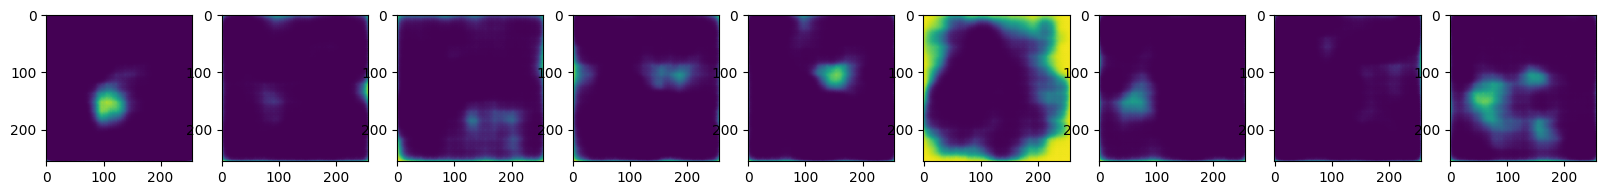

In [72]:
fig ,ax = plt.subplots(1,9, figsize = (20,10))
for i in range(9):
        ax[i].imshow(samples[i].reshape(256,256))

plt.show()

In [79]:
z = (torch.randn((20,64))).to(device)[0].reshape(1,64)
samples = []
for i in range(19):
    with torch.no_grad():
        decoded = model.decode(z)
        samples.append(decoded.cpu().detach().numpy())
        mu, logvar = model.encode(decoded)
        z = model.reparameterize(mu, logvar)



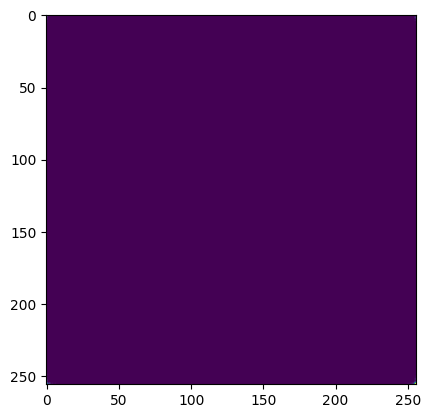

In [80]:
plt.imshow(samples[-1].reshape(256,256))

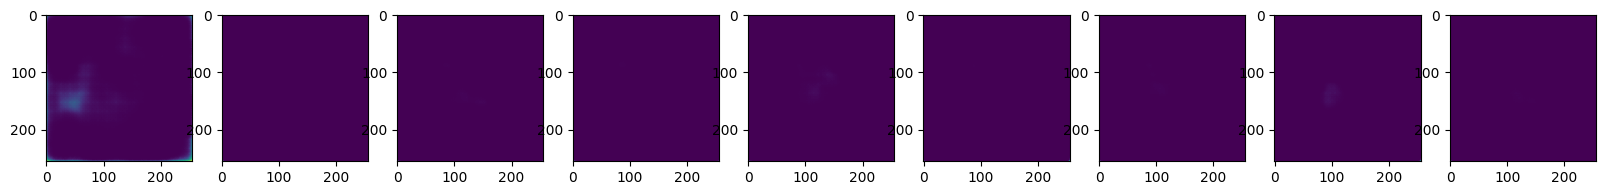

In [81]:
fig ,ax = plt.subplots(1,9, figsize = (20,10))
for i in range(9):
        ax[i].imshow(samples[i].reshape(256,256))

plt.show()

In [51]:
torch.save(model, "model.pth")

Latent dimension: 64
Shape of generated images: (100, 1, 256, 256)


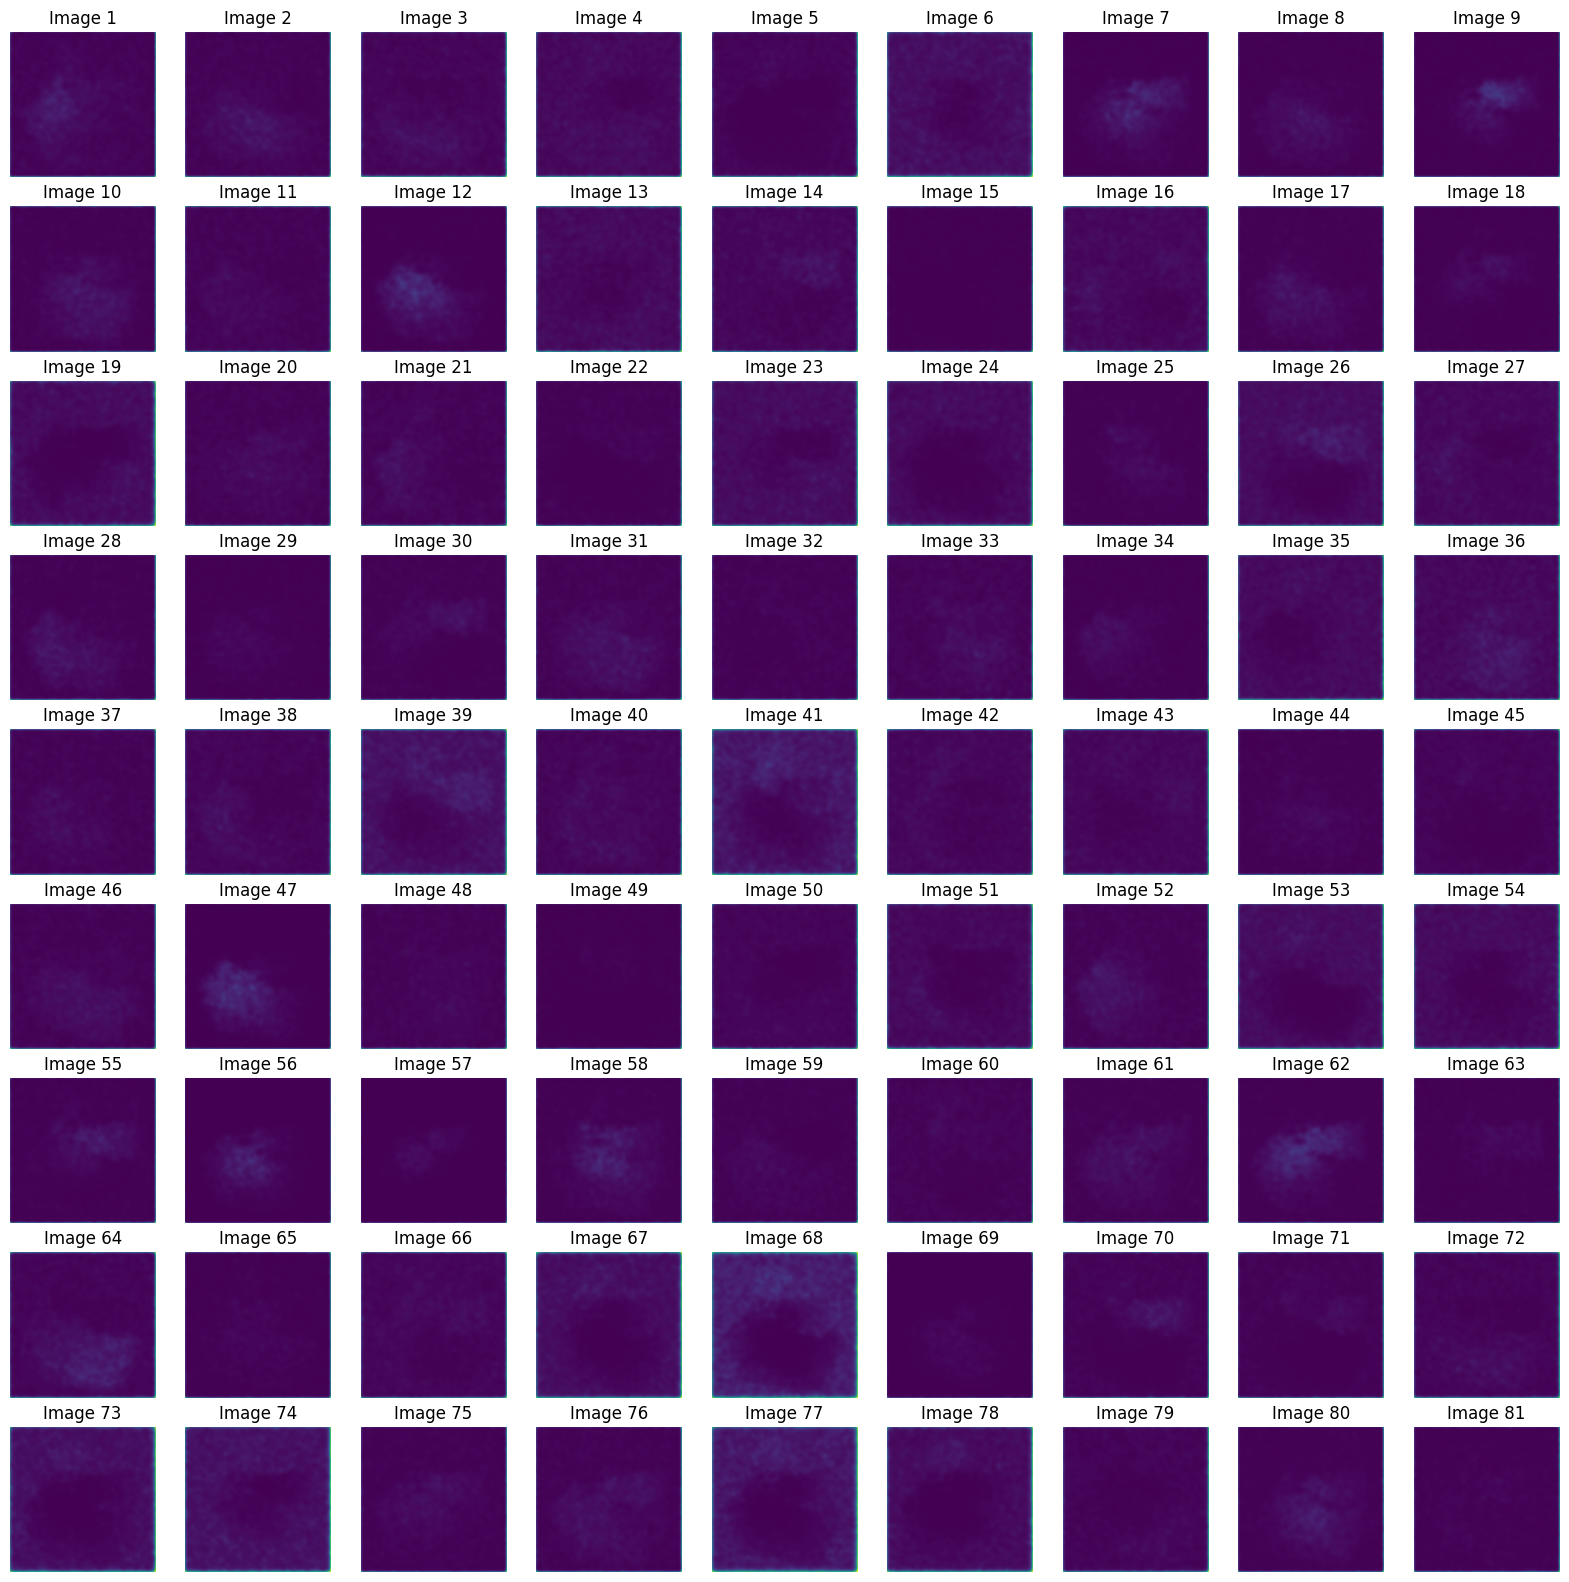

In [53]:
num_images = 100

# Sample latent vectors z from the standard normal distribution
latent_dim =64# Ensure this matches the latent dimension of your model
print(f"Latent dimension: {latent_dim}")
z = torch.randn(num_images, latent_dim).to(device)

# Generate images from the latent vectors
with torch.no_grad():
    generated_images = model.decode(z).cpu().numpy()

print(f"Shape of generated images: {generated_images.shape}")

# threshold_low = 0.3
# threshold_high = 0.5
# generated_images[generated_images < threshold_low] = 0
# generated_images[generated_images > threshold_high] = 1

# Reshape the generated images to their original dimensions
generated_images = generated_images.reshape(num_images, 256, 256)  # Adjust to your image dimensions

# Plot the 100 generated images
fig, axes = plt.subplots(9, 9, figsize=(20, 20))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(generated_images[i])
    ax.axis('off')
    ax.set_title(f'Image {i + 1}')

In [ ]:
###TDL
### change size back to normal
### test whether it changes
### try different architecture
### change loss